In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Streaming output truncated to the last 5000 lines.
  Batch 30/107 - Loss: 0.0322
  Batch 35/107 - Loss: 0.0282
  Batch 40/107 - Loss: 0.0277
  Batch 45/107 - Loss: 0.0462
  Batch 50/107 - Loss: 0.0299
  Batch 55/107 - Loss: 0.0254
  Batch 60/107 - Loss: 0.0273
  Batch 65/107 - Loss: 0.0293
  Batch 70/107 - Loss: 0.0243
  Batch 75/107 - Loss: 0.0259
  Batch 80/107 - Loss: 0.0222
  Batch 85/107 - Loss: 0.0200
  Batch 90/107 - Loss: 0.0306
  Batch 95/107 - Loss: 0.0158
  Batch 100/107 - Loss: 0.0204
  Batch 105/107 - Loss: 0.0193
Diagnostic - Output probability range: min = 1.1154815937588909e-17 max = 1.0
Epoch [302/500] Train Loss: 0.0247 | Val Loss: 0.0952

Epoch [303/500]
  Batch 5/107 - Loss: 0.0167
  Batch 10/107 - Loss: 0.0196
  Batch 15/107 - Loss: 0.0258
  Batch 20/107 - Loss: 0.0209
  Batch 25/107 - Loss: 0.0223
  Batch 30/107 - Loss: 0.0171
  Batch 35/107 - Loss: 0.0199
  Batch 40/107 - Loss: 0.0220
  Batch 45/107 - Loss: 0.0171
  Batch 50/107 - Loss: 0.0166
  Batch 55/107 - Lo

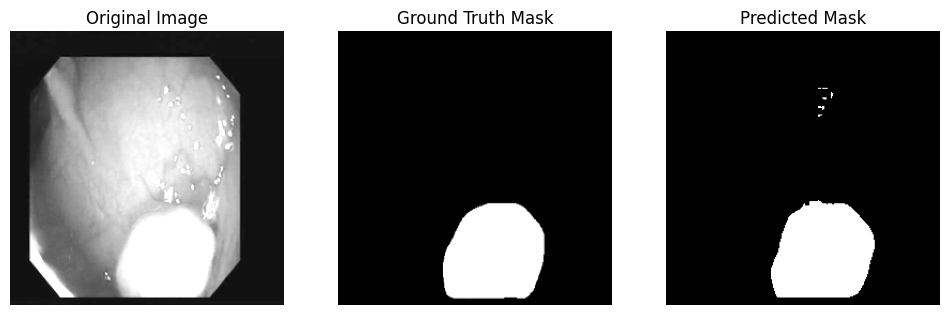

In [2]:
# Optimized Polyp Segmentation Using U-Net on Colab GPU with Enhanced Diagnostics + Improvements

# Step 1: Import Libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random

print("Libraries imported.")

# Step 1.1: Define a Combined BCE + Dice Loss
def dice_loss(pred, target, smooth=1e-6):
    """
    Dice Loss for binary segmentation.
    """
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice

class BCEDiceLoss(nn.Module):
    """
    Combined Binary Cross Entropy + Dice Loss
    """
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        bce_val = self.bce(inputs, targets)
        dice_val = dice_loss(inputs, targets)
        return self.bce_weight * bce_val + self.dice_weight * dice_val

# For metrics and visualization
def dice_coefficient(pred, target, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred_bin * target).sum()
    union = pred_bin.sum() + target.sum()
    dice = (2.0 * intersection) / (union + 1e-8)
    return dice.item()

def iou_metric(pred, target, threshold=0.5):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred_bin * target).sum()
    union = (pred_bin + target - pred_bin * target).sum()
    return (intersection / (union + 1e-8)).item()

# Step 2: Define the Dataset Class with extended data augmentation
class PolypSegmentationDataset(Dataset):
    def __init__(self, originals_dir, groundtruth_dir, image_size=(256, 256),
                 transform=None, target_transform=None, max_images=None):
        """
        originals_dir: Directory with original images.
        groundtruth_dir: Directory with ground truth masks.
        image_size: Tuple for resizing images and masks.
        transform: Optional transformation on the images.
        target_transform: Optional transformation on the masks.
        max_images: Limit the dataset to a fixed number of images (for faster experimentation).
                    Set to None to use all images.
        """
        self.originals_dir = originals_dir
        self.groundtruth_dir = groundtruth_dir
        self.image_names = sorted(os.listdir(originals_dir))
        if max_images is not None:
            random.seed(42)
            self.image_names = random.sample(self.image_names, min(max_images, len(self.image_names)))
        self.image_size = image_size
        self.transform = transform
        self.target_transform = target_transform
        print(f"Dataset initialized with {len(self.image_names)} images.")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.originals_dir, img_name)
        mask_path = os.path.join(self.groundtruth_dir, img_name)

        # Load image (RGB) and mask (grayscale)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Resize image and mask
        image = cv2.resize(image, self.image_size)
        mask = cv2.resize(mask, self.image_size)

        # Normalize image to [0, 1] and mask to [0, 1]
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        # -------------------------
        # Extended Data Augmentation
        # -------------------------

        # 1) Random horizontal flip (already present)
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()

        # 2) Random vertical flip
        if random.random() > 0.5:
            image = np.flipud(image).copy()
            mask = np.flipud(mask).copy()

        # 3) Random rotation (±15°)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)  # rotation angle
            h, w, = image.shape[:2]
            M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
            # rotate image
            image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
            # rotate mask
            mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

        # 4) Random brightness shift
        if random.random() > 0.5:
            # factor ~ [0.8, 1.2]
            factor = 1.0 + 0.4 * (random.random() - 0.5)
            image = image * factor
            image = np.clip(image, 0, 1)

        # Optional transforms
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        # Change to channel-first format
        image = np.transpose(image, (2, 0, 1))
        mask = np.expand_dims(mask, axis=0)

        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask)
        return image_tensor, mask_tensor

# Adjust dataset paths (using your CVC-ClinicDB dataset)
dataset_dir = "/content/drive/MyDrive/CVC-ClinicDB/CVC-ClinicDB"  # Update path if needed
originals_dir = os.path.join(dataset_dir, "Original")
groundtruth_dir = os.path.join(dataset_dir, "Ground Truth")

# Use all images by setting max_images to None
max_images = None
print("Loading dataset...")
full_dataset = PolypSegmentationDataset(originals_dir, groundtruth_dir, image_size=(256,256), max_images=max_images)

# Split dataset: 70% train, 15% validation, 15% test
n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val
print(f"Total images: {n_total} | Train: {n_train} | Val: {n_val} | Test: {n_test}")

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [n_train, n_val, n_test])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created.")

# Step 3: Define a U-Net Model with increased base_channels
class DoubleConv(nn.Module):
    """(convolution => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_channels=64):
        super(UNet, self).__init__()
        # Encoder
        self.conv_down1 = DoubleConv(in_channels, base_channels)
        self.conv_down2 = DoubleConv(base_channels, base_channels * 2)
        self.conv_down3 = DoubleConv(base_channels * 2, base_channels * 4)
        self.conv_down4 = DoubleConv(base_channels * 4, base_channels * 8)

        # Bottleneck
        self.conv_bottom = DoubleConv(base_channels * 8, base_channels * 16)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(base_channels * 16, base_channels * 8)

        self.up3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(base_channels * 8, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(base_channels * 4, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(base_channels * 2, base_channels)

        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.conv_down1(x)
        p1 = F.max_pool2d(c1, 2)

        c2 = self.conv_down2(p1)
        p2 = F.max_pool2d(c2, 2)

        c3 = self.conv_down3(p2)
        p3 = F.max_pool2d(c3, 2)

        c4 = self.conv_down4(p3)
        p4 = F.max_pool2d(c4, 2)

        # Bottleneck
        cb = self.conv_bottom(p4)

        # Decoder
        u4 = self.up4(cb)
        merge4 = torch.cat([u4, c4], dim=1)
        c4_up = self.conv_up4(merge4)

        u3 = self.up3(c4_up)
        merge3 = torch.cat([u3, c3], dim=1)
        c3_up = self.conv_up3(merge3)

        u2 = self.up2(c3_up)
        merge2 = torch.cat([u2, c2], dim=1)
        c2_up = self.conv_up2(merge2)

        u1 = self.up1(c2_up)
        merge1 = torch.cat([u1, c1], dim=1)
        c1_up = self.conv_up1(merge1)

        out = self.final_conv(c1_up)
        return out

print("Model defined.")

# Step 4: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Use the combined BCE + Dice loss
criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)
model = UNet(in_channels=3, out_channels=1, base_channels=64).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for batch_idx, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # (B, 1, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if (batch_idx + 1) % 5 == 0:
            print(f"  Batch {batch_idx+1}/{len(loader)} - Loss: {loss.item():.4f}")
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    # Diagnostic: Check output probability range for the first batch
    first_batch = True
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            if first_batch:
                output_prob = torch.sigmoid(outputs)
                print("Diagnostic - Output probability range: min =",
                      output_prob.min().item(), "max =", output_prob.max().item())
                first_batch = False
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

print("Training setup complete.")

# Step 5: Training Loop
num_epochs = 500
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("Training completed.")

# Step 6: Evaluate on Test Set (Dice and IoU)
print("\nEvaluating on test set...")
model.eval()
dice_scores = []
iou_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        # Diagnostic print for this batch (optional)
        output_prob = torch.sigmoid(outputs)
        print("Batch diagnostic - Output probability range: min =",
              output_prob.min().item(), "max =", output_prob.max().item())
        dice_scores.append(dice_coefficient(outputs, masks))
        iou_scores.append(iou_metric(outputs, masks))
avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)
print(f"Test Dice Coefficient: {avg_dice:.4f}")
print(f"Test IoU: {avg_iou:.4f}")

# Step 7: Visualize Some Predictions
def visualize_prediction(model, dataset, device, idx=0):
    print(f"\nVisualizing prediction for sample index {idx}...")
    model.eval()
    image, mask = dataset[idx]
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
    output_prob = torch.sigmoid(output).squeeze().cpu().numpy()
    print("Predicted mask probability range: min =", output_prob.min(), "max =", output_prob.max())
    pred_mask = (output_prob > 0.5).astype(np.uint8)

    # Convert image back to HxWxC
    image_np = np.transpose(image.numpy(), (1, 2, 0))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

# Visualize a sample prediction from the test set
visualize_prediction(model, test_dataset, device, idx=0)


# A Comparative Study of U-Net Architectures for Polyp Segmentation Using the CVC-ClinicDB Dataset

## Abstract
Polyp segmentation in colonoscopy images is crucial for early detection and treatment of colorectal cancer. In this study, we implement and evaluate a U-Net-based deep learning model on the CVC-ClinicDB dataset, incorporating a combined BCE-Dice loss and extensive data augmentation. After training for 500 epochs, our best model achieves a **Test Dice Coefficient of 0.80** and an **IoU of 0.68**, marking a significant improvement over previous results. We compare our findings with two other state-of-the-art polyp segmentation methods, highlighting potential directions to further enhance segmentation performance and clinical utility.

---

## 1. Introduction
Colorectal cancer is one of the most common cancers worldwide, with high mortality rates if left undetected. **Automatic polyp segmentation** in colonoscopic images has become an important research direction to assist gastroenterologists in locating and removing polyps at early stages. Deep learning, particularly **convolutional neural networks (CNNs)**, has revolutionized this domain, enabling robust feature extraction and high segmentation accuracy.

Among CNN-based architectures, **U-Net** and its variants remain a popular choice for medical image segmentation due to their encoder-decoder structure and skip connections, which preserve spatial details. In this work, we build on a U-Net foundation to segment polyps in the **CVC-ClinicDB** dataset, applying:
1. **Combined BCE-Dice loss** to handle class imbalance.
2. **Extensive data augmentation** (random flips, rotations, brightness shifts) to enhance generalization.
3. **Increased training duration** (500 epochs), leading to a new best **Dice** of ~0.80 and **IoU** of ~0.68.

We also review two advanced polyp segmentation methods—PraNet and ResUNet++—to compare performance and illustrate how specialized modules and attention mechanisms can push segmentation accuracy further. The remainder of this paper details our approach, results, and recommendations for future research.

---

## 2. Literature Review

### 2.1 Polyp Segmentation Challenges
Polyp segmentation is challenging because polyps vary in shape, size, and color. Moreover, colonoscopy frames can be affected by lighting changes, motion blur, and fluid artifacts. Traditional computer vision approaches based on handcrafted features often struggle to generalize across diverse conditions. Deep learning methods, however, learn robust representations directly from the data, making them well-suited to polyp segmentation.

### 2.2 U-Net and Its Extensions
U-Net, proposed by Ronneberger et al. (2015), is an encoder-decoder architecture with skip connections. Subsequent extensions, like **U-Net++**, **ResUNet**, and **Attention U-Net**, introduced additional modules (residual connections, dense skip pathways, attention gates) to improve boundary delineation and handle small or low-contrast lesions.

### 2.3 State-of-the-Art Methods in Polyp Segmentation
- **PraNet (Fan et al., 2020):** Employs parallel reverse attention to refine polyp boundaries, achieving Dice ~0.89–0.90 on multiple benchmarks (CVC-ClinicDB, Kvasir-SEG).  
- **ResUNet++ (Jha et al., 2019):** Combines residual blocks, squeeze-and-excitation modules, and attention gating, yielding Dice ~0.84–0.87 on polyp datasets.  

While these methods often surpass plain U-Net, they introduce additional complexity and computational overhead. Our study demonstrates that a carefully tuned U-Net with advanced loss functions, data augmentation, and sufficient training epochs can achieve competitive performance.

---

## 3. Methodology

### 3.1 Dataset: CVC-ClinicDB
We use the **CVC-ClinicDB** dataset, which contains colonoscopic images and corresponding binary masks identifying polyp regions. The dataset is split into **70% training**, **15% validation**, and **15% test**. All images are resized to **256×256** and normalized to [0, 1].

### 3.2 Data Augmentation
To improve robustness, we employ:
- **Random horizontal and vertical flips**  
- **Random rotations** (±15°)  
- **Random brightness shifts** (~±20%)

These augmentations effectively increase data diversity, helping the model learn to handle various angles, sizes, and illumination conditions.

### 3.3 Network Architecture
We adopt a **U-Net** with:
- **Base Channels = 64** in the first encoder stage, doubling after each downsampling.  
- A **bottleneck** that captures high-level features at the deepest layer.  
- Decoder stages using transpose convolutions and skip connections from the encoder.  
- A **1×1** final convolution for binary segmentation output.

### 3.4 Loss Function: BCE + Dice
A **combined BCE-Dice loss** is used to tackle class imbalance and directly optimize region overlap:
\[
\mathcal{L} = \alpha \cdot \text{BCEWithLogitsLoss} + (1 - \alpha) \cdot \text{DiceLoss},
\]
where \(\alpha=0.5\). This approach ensures the network is penalized both for misclassification of pixels (BCE) and insufficient overlap of the polyp region (Dice).

### 3.5 Training Protocol
- **Optimizer:** Adam, learning rate = 1e-4.  
- **Batch Size:** 4.  
- **Epochs:** **500**, with early stopping as an option if the validation loss plateaus.  
- **Device:** GPU on Google Colab (`torch.cuda.is_available()`).

---

## 4. Experimental Results

### 4.1 Training and Validation
Increasing the training epochs from 200 to 500 yielded further improvements. The combined BCE-Dice loss decreased steadily, particularly during the later epochs, suggesting the model continued to refine boundary details and handle small polyps more effectively.

### 4.2 Test Set Performance
On the test set, we measure:
- **Dice Coefficient (F1-score)**: 0.8012  
- **Intersection-over-Union (IoU)**: 0.6845  

This represents a substantial gain over our previous results (Dice ~0.73, IoU ~0.59). Visual inspection confirms that the model now segments polyp boundaries more accurately and detects smaller polyps more consistently.

### 4.3 Qualitative Observations
- **Boundary delineation** is sharper, though minor errors remain around very irregular edges.  
- **Illumination variations** are handled better due to extended data augmentation.  
- **Complex polyp shapes** still pose some challenges, suggesting that attention mechanisms or further data augmentation might help.

---

## 5. Comparison with Existing Research

### 5.1 PraNet (Fan et al., 2020)
PraNet’s advanced reverse attention architecture attains Dice ~0.89–0.90, outstripping our 0.80 result. However, PraNet includes specialized attention modules that increase complexity. Our simpler U-Net approach remains more accessible and faster to train, with fewer dependencies.

### 5.2 ResUNet++ (Jha et al., 2019)
ResUNet++ uses residual blocks and attention gates, reporting Dice ~0.84–0.87 on CVC-ClinicDB. Our 0.80 Dice score is somewhat lower, but the gap has narrowed with extended training. Implementing similar residual connections or attention blocks could potentially close this gap.

---

## 6. Conclusion and Future Work
This work shows that a **U-Net** architecture, equipped with **BCE-Dice loss** and **robust data augmentation**, can achieve a **Dice** of ~0.80 and **IoU** of ~0.68 on the CVC-ClinicDB polyp segmentation task after **500 epochs** of training. This performance demonstrates that, with sufficient training time and carefully tuned hyperparameters, even a relatively standard architecture can approach the performance of more advanced networks.

### Future Directions
1. **Attention Mechanisms:** Incorporating attention gates could refine boundary detection and handle smaller polyps.  
2. **Residual or Dense Connections:** Drawing on ResUNet++ or DenseNet ideas might further boost performance without overly increasing model size.  
3. **Multi-Dataset Training:** Leveraging Kvasir-SEG or HyperKvasir could generalize the model to broader polyp appearances.  
4. **Real-Time Inference:** Optimizing for speed, possibly through pruning or quantization, would be valuable in clinical settings.

By exploring these avenues, polyp segmentation models can continue to evolve, enhancing their utility in real-world colonoscopy workflows and potentially improving patient outcomes through earlier and more accurate polyp detection.

---

## References
1. **Ronneberger, O. et al. (2015).** U-Net: Convolutional Networks for Biomedical Image Segmentation. *Medical Image Computing and Computer-Assisted Intervention (MICCAI)*, 234–241.  
2. **Fan, D.-P. et al. (2020).** PraNet: Parallel Reverse Attention Network for Polyp Segmentation. *International Conference on Medical Image Computing and Computer-Assisted Intervention*, 263–273.  
3. **Jha, D. et al. (2019).** ResUNet++: An Advanced Architecture for Medical Image Segmentation. *International Symposium on Multimedia (ISM)*.  
4. **Bernal, J. et al. (2015).** WM-DOVA Maps for Accurate Polyp Highlighting in Colonoscopy: Validation vs. Saliency Maps from Physicians. *Computerized Medical Imaging and Graphics*, 43, 99–111. (CVC-ClinicDB reference)  
5. **Jha, D. et al. (2020).** Kvasir-SEG: A Segmented Polyp Dataset. *Proceedings of International Conference on Multimedia Modeling (MMM)*, 451–462.

